In [1]:
# Importing Dependencies

import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping
import matplotlib as plt
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%pylab inline


import pandas as pd
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
from sklearn.utils import shuffle
from numpy import asarray
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, SpatialDropout1D


import sys
sys.path.append('../')
from Utilities.model_visualization import model_to_png



print('Imports Done')

C:\Users\Javapocalypse\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
Imports Done


In [2]:
def plot_image(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()

In [3]:
def load_image(img_path, img_width, img_height):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor

In [4]:
def get_image_model():
    # Params for CNN
    img_width, img_height = 150, 150
    # Loading vgg except the final layer
    vgg_conv = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    # Freeze the layers except the last 4 layers
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False
    model_top = Sequential()
    # Add the vgg convolutional base model
    model_top.add(vgg_conv)
    model_top.add(Flatten())
    model_top.add(Dense(256, activation='relu'))
    model_top.add(Dropout(0.5))
    model_top.add(Dense(256, activation='relu'))
    model_top.add(Dropout(0.5))
    model_top.add(Dense(256, activation='relu'))
    model_top.add(Dropout(0.2))
    model_top.add(Dense(3, activation='sigmoid'))
    model_top.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ## Load wieghts
    model_top.load_weights('fine-tined-8574-newdata.h5')
    return model_top

In [5]:
def predict_image(img_path):
    model = get_image_model()
    # Plot Image
    plot_image(img_path)
    # Params for CNN
    img_width, img_height = 150, 150
    # load a single image
    new_image = load_image(img_path, img_width, img_height)
    # check prediction
    pred = model.predict(new_image)
    high_conf = pred[0][0]
    low_conf = pred[0][1]
    moderate_conf = pred[0][2]
#     labels = ['Severe Damage', 'Little Damage','Mild Damage']
#     print('Classified as: '+labels[np.argmax(pred)])
    model = None
    return high_conf, low_conf, moderate_conf

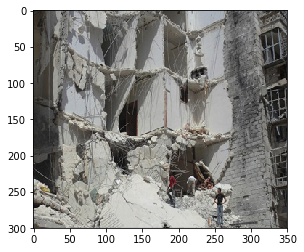

Classified as: Severe Damage


In [7]:
# pred = predict_image('predict/1.jpg')
# labels = ['Severe Damage', 'Little Damage','Mild Damage']
# print('Classified as: '+ labels[np.argmax(pred)])

In [8]:
def predict_text(text):
    model = get_text_model()
    df = pd.read_excel('tweets.xlsx')
    # Max number of words in each tweet.
    MAX_SEQUENCE_LENGTH = 250
    # The maximum number of words to be used. (most frequent)
    MAX_NB_WORDS = 50000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['text'].values)
    word_index = tokenizer.word_index
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    high_conf = pred[0][3]
    moderate_conf = pred[0][2]
    low_conf = pred[0][1]
    irrelevant_conf = pred[0][0]
#     labels = ['Don\'t know or can\'t say','Little Damage','Mild Damage','Severe Damage']
#     print('Text: '+ text, '\nClassified as: '+labels[np.argmax(pred)])
    model = None
    return irrelevant_conf, high_conf, low_conf, moderate_conf

In [9]:
def get_text_model():
    # The maximum number of words to be used. (most frequent)
    MAX_NB_WORDS = 50000
    # Max number of words in each tweet.
    MAX_SEQUENCE_LENGTH = 250
    # This is fixed.
    EMBEDDING_DIM = 100
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.load_weights('lstm_text.h5')
    return model

In [46]:
# text = 'Moment deadly earthquake rocked Iraq amp Iran caught on VIDEO'
# pred = predict_text(text)
# labels = ['Don\'t know or can\'t say','Severe Damage','Little Damage','Mild Damage']
# print('Text: '+ text, '\nClassified as: '+ labels[np.argmax(pred)])

Text: Moment deadly earthquake rocked Iraq amp Iran caught on VIDEO 
Classified as: Severe Damage


In [10]:
def calculate_wtg(obtained, wtg):
    return (wtg / 100) * (obtained*100)

In [11]:
def hybrid(image_path, text):
    img_high_conf, img_low_conf, img_moderate_conf =  predict_image(image_path)
    text_dont_know_conf, text_high_conf, text_low_conf, text_moderate_conf = predict_text(text)
    wtg_img = 80
    wtg_text = 20
    high = calculate_wtg(img_high_conf, wtg_img) + calculate_wtg(text_high_conf, wtg_text)
    moderate = calculate_wtg(img_moderate_conf, wtg_img) + calculate_wtg(text_moderate_conf, wtg_text)
    low = calculate_wtg(img_low_conf, wtg_img) + calculate_wtg(text_low_conf, wtg_text)
    labels = ['Severe Damage', 'Moderate Damage', 'Low/No Damage']
    print('Text: ',text,'\n', '-'*35)
    print('  Model Prediction : ', labels[np.argmax([high, moderate, low])], '\n', '-'*35, '\n')
    print('Log:')
    print('Severe Damage: ', round(high,2), '%\nModerate Damage: ', round(moderate,2), '%\nLow/No Damage: ', round(low,2), '%')
    print('-'*35)
    print('\n\n\n')

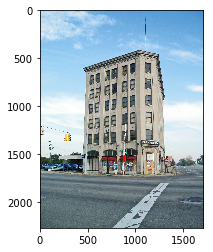

Text:  A masterpiece in tokyo 
 -----------------------------------
  Model Prediction :  Low/No Damage 
 ----------------------------------- 

Log:
Severe Damage:  14.51 %
Moderate Damage:  24.62 %
Low/No Damage:  64.0 %
-----------------------------------






In [19]:
hybrid('predict/t5.jpg', 'A masterpiece in tokyo')